<a href="https://colab.research.google.com/github/asgutierrt/Introduction-to-IA/blob/main/neural_networks/mlp_sympy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notas clase IA

# Perceptrones individuales

In [ ]:
# funciones de activacion
a=1; b=0
phi_1=lambda V: a*V+b # lineal
phi_2=lambda V: (exp(1)**(V)-exp(1)**(-V))/(exp(1)**(V)+exp(1)**(-V)) # tanh
phi_3=lambda V: 1/(1+exp(1)**-V) # sigmoid

import numpy as np
X=np.array([(0,0),(0,1),(1,0),(1,1)]) # 1. Entradas: x puntos en el espacio R^n

# Modelo general - salida deseada
M1 = np.array([[all(xi)*1] for xi in X]) #and
M2 = np.array([[any(xi)*1] for xi in X]) #or
M3 = np.array([[(any(xi) and not all(xi))*1] for xi in X]) #xor

Y_d=M1
Y_d.T

In [ ]:
from sympy import *
from scipy.optimize import minimize

def perceptron (X,Y_d,phi):
  # 3. Campo local inducido: combinacion lineal de cada entrada/estimulo. Los coeficientes son variables que se deben encontrar optimizando una funcion de costo
  W=symarray('w',int(X.shape[1]))
  V=np.sum(W*X,axis=1)
  Y=phi(V) # 4. funcion de activacion: funcion con la que se intenta acercar al modelo (curva parametrica)
  J=np.sum((Y_d.T-Y)**2)/2 # 5. Plantear el problema de optimizacion: minimizar la funcion de costo

  # 6. Solucionar el problema de optimizacion
  ## por diferenciacion
  #dJ=[J.diff(w_i) for w_i in W]
  #sol=list(solve(dJ).values()) #solucion exacta
  #sol=nsolve(dJ, W, (-1, -1)).T #solucion numerica
  ## scipy minimizer
  sol=minimize(lambda x: J.subs([(wi, xi) for wi,xi in zip(W,x)]), x0=[-1,-1]).x
  return sol

In [ ]:
phi=phi_1
sol=perceptron (X,Y_d,phi)
sol

array([0.33333333, 0.33333333])

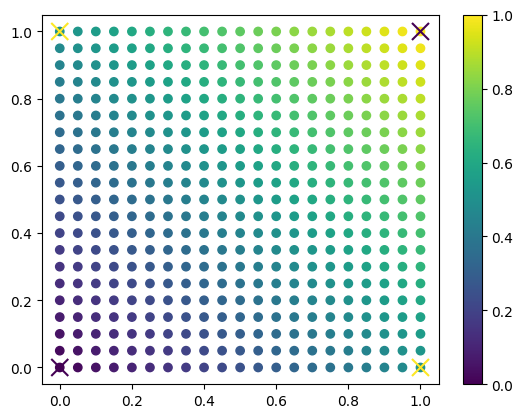

In [ ]:
# puntos a graficar
n=2
from itertools import product
x0,x1= zip(*product(np.arange(0,1.01,0.05),repeat=n))
axis=symarray('x',n)
# evaluar en la funcion de activacion
Y_eval=[phi(np.sum(sol*axis)).subs(list(zip(axis,(x0,x1)))) for x0,x1 in zip(x0,x1)]

import matplotlib.pyplot as plt
plt.scatter(x0,x1,c=Y_eval,marker='o')
plt.scatter(X[:,0],X[:,1],c=Y_d,marker='x',s=150)
plt.colorbar()

In [ ]:
for i, Y_d in enumerate([M1,M2,M3]):
  print("Modelo: ",i)
  for phi in [phi_1,phi_2,phi_3]:
    sol=perceptron (X,Y_d,phi)
    print(sol)

Modelo:  0
[0.3333333  0.33333333]
[0.32741615 0.32741616]
[-2.69604747e-07 -2.60004087e-07]
Modelo:  1
[0.66666663 0.66666663]
[3.55874469 3.55874469]
[6.04752989 6.04752989]
Modelo:  2
[0.33333333 0.33333333]
[3.27642853 3.27641068]
[1.42020679e-05 1.42091724e-05]


# Multilayer perceptron

In [ ]:
# requerimientos
import numpy as np
from sympy import *
from itertools import product
from scipy.optimize import minimize

# funciones de activacion
a=1; b=0
v = symbols("v")
phi_1=a*v+b # lineal
phi_2=(exp(v)-exp(-v))/(exp(v)+exp(-v)) # tanh
phi_3=1/(1+exp(-v)) # sigmoid

# Modelo general - salida deseada
M1 = lambda X: np.array([[all(xi)*1]*2 for xi in X]) #and
M2 = lambda X: np.array([[any(xi)*1] for xi in X]) #or
M3 = lambda X: np.array([[(any(xi) and not all(xi))*1] for xi in X]) #xor

# Solucionar el problema de aprendizaje
X=np.array([(0,0),(0,1),(1,0),(1,1)]) # 1. Entradas: x puntos en el espacio R^n
Y_d=M1(X)
Y_d=Y_d/np.max(Y_d, axis=0) # normalizar
Y_d

array([[0., 0.],
       [0., 0.],
       [0., 0.],
       [1., 1.]])

In [ ]:
def build_layer(x,m,phi,label):
  n=int(x.shape[0]) # entradas a cada perceptron
  W=Matrix(symarray('W'+str(label), (m, n))) # variables w para la capa
  V=W*x # campo local inducido en cada perceptron
  # funcion de activacion evaluada en el campo de los m perceptrones
  Y=Matrix(m,1, lambda i,j: phi.subs({"v":V[i,j]}))
  return Y, W, V

# MLP example
n=X.shape[1]; mx=Matrix(symarray('X', n)) # input
# MLP
mi=2; phi_i=phi_1
li, wi, vi=build_layer(mx,mi,phi_i,"i")
mj=2; phi_j=phi_1
lj, wj, vj=build_layer(li,mj,phi_j,"j")
mk=Y_d.shape[1]; phi_k=phi_1;
lk, wk, vk=build_layer(lj,mk,phi_k,"k")

model, w_vars= lk, list(wi)+list(wj)+list(wk) # output

In [ ]:
class MLP:
  __slots__ = ["wx","y","conf"]
  def __init__(self,layers_setup,X):
    self.wx=Matrix(symarray('X', X.shape[1]))
    self.y=None
    # configuration dictionary
    self.conf={}
    self.build_model(layers_setup) # informacion de capa capa
    self.rnd_w_vals() # inicializar valores w aleatorios

  def rnd_w_vals(self):
    for layer in self.conf:
      self.conf[layer].update({"W_vals":Matrix(np.random.rand(self.conf[layer]['W'].shape[0],self.conf[layer]['W'].shape[1]))})

  def build_model(self,layers_setup):
    last_layer=-1
    for layer,(neuronas,phi) in enumerate(layers_setup):
      entrada= self.conf[last_layer]['Y'] if last_layer!=-1 else self.wx
      self.conf[layer]=dict(zip(['Y','W','V'],self.build_layer(entrada,neuronas,phi,layer)))
      self.conf[layer].update({'X':entrada,'Phi':phi})
      last_layer=layer
    self.y=self.conf[last_layer]

  def build_layer(self,x,m,phi,label):
    n=int(x.shape[0]) # entradas a cada perceptron
    W=Matrix(symarray('W'+str(label), (m, n))) # variables w para la capa
    V=W*x # campo local inducido en cada perceptron
    # funcion de activacion evaluada en el campo de los m perceptrones
    Y=Matrix(m,1, lambda i,j: phi.subs({"v":V[i,j]}))
    return Y, W, V

In [ ]:
model=MLP([(2,phi_1),(2,phi_1),(Y_d.shape[1],phi_1)],X)
model.conf[0]

{'Y': Matrix([
 [W0_0_0*X_0 + W0_0_1*X_1],
 [W0_1_0*X_0 + W0_1_1*X_1]]),
 'W': Matrix([
 [W0_0_0, W0_0_1],
 [W0_1_0, W0_1_1]]),
 'V': Matrix([
 [W0_0_0*X_0 + W0_0_1*X_1],
 [W0_1_0*X_0 + W0_1_1*X_1]]),
 'X': Matrix([
 [X_0],
 [X_1]]),
 'Phi': v,
 'W_vals': Matrix([
 [0.927380593333002, 0.604532181323065],
 [0.219442054448761, 0.395063338367931]])}

In [ ]:
error=0
error_m=Matrix(len(X), mk, lambda i,j: 0)
for p in range(len(X)):
  ep=Y_d[p].reshape((-1,1))-model.subs(zip(mx,X[p]))
  ep_v=ep.T*ep/2
  error+=ep_v[0]
  error_m[p,:]=ep.T
error_m

In [ ]:
# minimizar el error usando la funcion minimize de sympy
minw=minimize(error,x0=[1]*len(w_vars), method='BFGS')
minw

# Resolver por descenso por el gradiente

## **resolver para un patron p**

Inicializar W en valores aleatorios, calcular los gradientes a partir del error del patron p y actualizar los valores en W

volver a evaluar el error con los nuevos valores W y comparar con el error con los W aleatorios


In [ ]:
# w inicial aleatoria
np.random.seed(10) # for generating the same results
wi_vals,wj_vals,wk_vals=[Matrix(np.random.rand(w.shape[0],w.shape[1])) for w in [wi,wj,wk]]
w_vals=[list(wi_vals)+list(wj_vals)+list(wk_vals)]; w_grads=[]

In [ ]:
p=0
# capa de salida k
display(wk)
init_local_grad_k=-1*(Y_d[p].reshape((-1,1))-model.subs(zip(mx,X[p])).subs(set(zip(wi,wi_vals))|set(zip(wj,wj_vals))|set(zip(wk,wk_vals))))
dy_dv=Matrix(wk.shape[0],1, lambda i,j: diff(phi_k,"v").subs({"v":vk[i]}))
local_grad_k=Matrix(1, init_local_grad_k.shape[1], lambda i,j: sum(init_local_grad_k[:,j])*dy_dv[j])
display(local_grad_k)

dv_dw=Matrix(wk.shape[0],wk.shape[1], lambda i,j: diff(vk[i],wk[i,j]))
dJ_dwk=Matrix(wk.shape[0], wk.shape[1], lambda i,j: (local_grad_k[0,i]*dv_dw[i,j]).subs(zip(mx,X[p])))
display(dJ_dwk)

# capa j
display(wj)
init_local_grad_j=Matrix(wk.shape[0], wk.shape[1], lambda i,j: (local_grad_k[0,i]*wk[i,j]).subs(zip(mx,X[p]))) # salidas en k*entradas en k
dy_dv=Matrix(wj.shape[0],1, lambda i,j: diff(phi_j,"v").subs({"v":vj[i]})) # salidas en j x 1 (entradas en k=salidas en j)
local_grad_j=Matrix(1, init_local_grad_j.shape[1], lambda i,j: sum(init_local_grad_j[:,j])*dy_dv[j])
display(local_grad_j)

dv_dw=Matrix(wj.shape[0],wj.shape[1], lambda i,j: diff(vj[i],wj[i,j]))
dJ_dwj=Matrix(wj.shape[0], wj.shape[1], lambda i,j: (local_grad_j[0,i]*dv_dw[i,j]).subs(zip(mx,X[p])))
display(dJ_dwj)

# capa i
display(wi)
init_local_grad_i=Matrix(wj.shape[0], wj.shape[1], lambda i,j: (local_grad_j[0,i]*wj[i,j]).subs(zip(mx,X[p]))) # salidas en j*entradas en j
dy_dv=Matrix(wi.shape[0],1, lambda i,j: diff(phi_i,"v").subs({"v":vi[i]})) # salidas en i x 1 (entradas en j=salidas en i)
local_grad_i=Matrix(1, init_local_grad_i.shape[1], lambda i,j: sum(init_local_grad_i[:,j])*dy_dv[j])
display(local_grad_i)

dv_dw=Matrix(wi.shape[0],wi.shape[1], lambda i,j: diff(vi[i],wi[i,j]))
dJ_dwi=Matrix(wi.shape[0], wi.shape[1], lambda i,j: (local_grad_i[0,i]*dv_dw[i,j]).subs(zip(mx,X[p])))
display(dJ_dwi)

Matrix([[Wk_0_0, Wk_0_1]])

Matrix([[-0.84025068691168]])

Matrix([[-0.84025068691168/(exp(-Wj_0_0*(-exp(-1.0*Wi_0_0 - 0.0325243297706515*Wi_0_1) + exp(1.0*Wi_0_0 + 0.0325243297706515*Wi_0_1))/(exp(-1.0*Wi_0_0 - 0.0325243297706515*Wi_0_1) + exp(1.0*Wi_0_0 + 0.0325243297706515*Wi_0_1)) - Wj_0_1*(-exp(-1.0*Wi_1_0 - 0.0325243297706515*Wi_1_1) + exp(1.0*Wi_1_0 + 0.0325243297706515*Wi_1_1))/(exp(-1.0*Wi_1_0 - 0.0325243297706515*Wi_1_1) + exp(1.0*Wi_1_0 + 0.0325243297706515*Wi_1_1))) + 1), -0.84025068691168/(exp(-Wj_1_0*(-exp(-1.0*Wi_0_0 - 0.0325243297706515*Wi_0_1) + exp(1.0*Wi_0_0 + 0.0325243297706515*Wi_0_1))/(exp(-1.0*Wi_0_0 - 0.0325243297706515*Wi_0_1) + exp(1.0*Wi_0_0 + 0.0325243297706515*Wi_0_1)) - Wj_1_1*(-exp(-1.0*Wi_1_0 - 0.0325243297706515*Wi_1_1) + exp(1.0*Wi_1_0 + 0.0325243297706515*Wi_1_1))/(exp(-1.0*Wi_1_0 - 0.0325243297706515*Wi_1_1) + exp(1.0*Wi_1_0 + 0.0325243297706515*Wi_1_1))) + 1)]])

Matrix([
[Wj_0_0, Wj_0_1],
[Wj_1_0, Wj_1_1]])

Matrix([[-0.84025068691168*Wk_0_0*exp(-Wj_0_0*(-exp(-Wi_0_0*X_0 - Wi_0_1*X_1) + exp(Wi_0_0*X_0 + Wi_0_1*X_1))/(exp(-Wi_0_0*X_0 - Wi_0_1*X_1) + exp(Wi_0_0*X_0 + Wi_0_1*X_1)) - Wj_0_1*(-exp(-Wi_1_0*X_0 - Wi_1_1*X_1) + exp(Wi_1_0*X_0 + Wi_1_1*X_1))/(exp(-Wi_1_0*X_0 - Wi_1_1*X_1) + exp(Wi_1_0*X_0 + Wi_1_1*X_1)))/(exp(-Wj_0_0*(-exp(-Wi_0_0*X_0 - Wi_0_1*X_1) + exp(Wi_0_0*X_0 + Wi_0_1*X_1))/(exp(-Wi_0_0*X_0 - Wi_0_1*X_1) + exp(Wi_0_0*X_0 + Wi_0_1*X_1)) - Wj_0_1*(-exp(-Wi_1_0*X_0 - Wi_1_1*X_1) + exp(Wi_1_0*X_0 + Wi_1_1*X_1))/(exp(-Wi_1_0*X_0 - Wi_1_1*X_1) + exp(Wi_1_0*X_0 + Wi_1_1*X_1))) + 1)**2, -0.84025068691168*Wk_0_1*exp(-Wj_1_0*(-exp(-Wi_0_0*X_0 - Wi_0_1*X_1) + exp(Wi_0_0*X_0 + Wi_0_1*X_1))/(exp(-Wi_0_0*X_0 - Wi_0_1*X_1) + exp(Wi_0_0*X_0 + Wi_0_1*X_1)) - Wj_1_1*(-exp(-Wi_1_0*X_0 - Wi_1_1*X_1) + exp(Wi_1_0*X_0 + Wi_1_1*X_1))/(exp(-Wi_1_0*X_0 - Wi_1_1*X_1) + exp(Wi_1_0*X_0 + Wi_1_1*X_1)))/(exp(-Wj_1_0*(-exp(-Wi_0_0*X_0 - Wi_0_1*X_1) + exp(Wi_0_0*X_0 + Wi_0_1*X_1))/(exp(-Wi_0_0*X_0 - Wi_0_1*

Matrix([
[-0.84025068691168*Wk_0_0*(-exp(-1.0*Wi_0_0 - 0.0325243297706515*Wi_0_1) + exp(1.0*Wi_0_0 + 0.0325243297706515*Wi_0_1))*exp(-Wj_0_0*(-exp(-1.0*Wi_0_0 - 0.0325243297706515*Wi_0_1) + exp(1.0*Wi_0_0 + 0.0325243297706515*Wi_0_1))/(exp(-1.0*Wi_0_0 - 0.0325243297706515*Wi_0_1) + exp(1.0*Wi_0_0 + 0.0325243297706515*Wi_0_1)) - Wj_0_1*(-exp(-1.0*Wi_1_0 - 0.0325243297706515*Wi_1_1) + exp(1.0*Wi_1_0 + 0.0325243297706515*Wi_1_1))/(exp(-1.0*Wi_1_0 - 0.0325243297706515*Wi_1_1) + exp(1.0*Wi_1_0 + 0.0325243297706515*Wi_1_1)))/((exp(-1.0*Wi_0_0 - 0.0325243297706515*Wi_0_1) + exp(1.0*Wi_0_0 + 0.0325243297706515*Wi_0_1))*(exp(-Wj_0_0*(-exp(-1.0*Wi_0_0 - 0.0325243297706515*Wi_0_1) + exp(1.0*Wi_0_0 + 0.0325243297706515*Wi_0_1))/(exp(-1.0*Wi_0_0 - 0.0325243297706515*Wi_0_1) + exp(1.0*Wi_0_0 + 0.0325243297706515*Wi_0_1)) - Wj_0_1*(-exp(-1.0*Wi_1_0 - 0.0325243297706515*Wi_1_1) + exp(1.0*Wi_1_0 + 0.0325243297706515*Wi_1_1))/(exp(-1.0*Wi_1_0 - 0.0325243297706515*Wi_1_1) + exp(1.0*Wi_1_0 + 0.03252432977

Matrix([
[Wi_0_0, Wi_0_1],
[Wi_1_0, Wi_1_1]])

Matrix([[((-exp(-Wi_0_0*X_0 - Wi_0_1*X_1) + exp(Wi_0_0*X_0 + Wi_0_1*X_1))*(exp(-Wi_0_0*X_0 - Wi_0_1*X_1) - exp(Wi_0_0*X_0 + Wi_0_1*X_1))/(exp(-Wi_0_0*X_0 - Wi_0_1*X_1) + exp(Wi_0_0*X_0 + Wi_0_1*X_1))**2 + 1)*(-0.84025068691168*Wj_0_0*Wk_0_0*exp(-Wj_0_0*(-exp(-1.0*Wi_0_0 - 0.0325243297706515*Wi_0_1) + exp(1.0*Wi_0_0 + 0.0325243297706515*Wi_0_1))/(exp(-1.0*Wi_0_0 - 0.0325243297706515*Wi_0_1) + exp(1.0*Wi_0_0 + 0.0325243297706515*Wi_0_1)) - Wj_0_1*(-exp(-1.0*Wi_1_0 - 0.0325243297706515*Wi_1_1) + exp(1.0*Wi_1_0 + 0.0325243297706515*Wi_1_1))/(exp(-1.0*Wi_1_0 - 0.0325243297706515*Wi_1_1) + exp(1.0*Wi_1_0 + 0.0325243297706515*Wi_1_1)))/(exp(-Wj_0_0*(-exp(-1.0*Wi_0_0 - 0.0325243297706515*Wi_0_1) + exp(1.0*Wi_0_0 + 0.0325243297706515*Wi_0_1))/(exp(-1.0*Wi_0_0 - 0.0325243297706515*Wi_0_1) + exp(1.0*Wi_0_0 + 0.0325243297706515*Wi_0_1)) - Wj_0_1*(-exp(-1.0*Wi_1_0 - 0.0325243297706515*Wi_1_1) + exp(1.0*Wi_1_0 + 0.0325243297706515*Wi_1_1))/(exp(-1.0*Wi_1_0 - 0.0325243297706515*Wi_1_1) + exp(1.0*Wi_1

Matrix([
[1.0*((-exp(-1.0*Wi_0_0 - 0.0325243297706515*Wi_0_1) + exp(1.0*Wi_0_0 + 0.0325243297706515*Wi_0_1))*(exp(-1.0*Wi_0_0 - 0.0325243297706515*Wi_0_1) - exp(1.0*Wi_0_0 + 0.0325243297706515*Wi_0_1))/(exp(-1.0*Wi_0_0 - 0.0325243297706515*Wi_0_1) + exp(1.0*Wi_0_0 + 0.0325243297706515*Wi_0_1))**2 + 1)*(-0.84025068691168*Wj_0_0*Wk_0_0*exp(-Wj_0_0*(-exp(-1.0*Wi_0_0 - 0.0325243297706515*Wi_0_1) + exp(1.0*Wi_0_0 + 0.0325243297706515*Wi_0_1))/(exp(-1.0*Wi_0_0 - 0.0325243297706515*Wi_0_1) + exp(1.0*Wi_0_0 + 0.0325243297706515*Wi_0_1)) - Wj_0_1*(-exp(-1.0*Wi_1_0 - 0.0325243297706515*Wi_1_1) + exp(1.0*Wi_1_0 + 0.0325243297706515*Wi_1_1))/(exp(-1.0*Wi_1_0 - 0.0325243297706515*Wi_1_1) + exp(1.0*Wi_1_0 + 0.0325243297706515*Wi_1_1)))/(exp(-Wj_0_0*(-exp(-1.0*Wi_0_0 - 0.0325243297706515*Wi_0_1) + exp(1.0*Wi_0_0 + 0.0325243297706515*Wi_0_1))/(exp(-1.0*Wi_0_0 - 0.0325243297706515*Wi_0_1) + exp(1.0*Wi_0_0 + 0.0325243297706515*Wi_0_1)) - Wj_0_1*(-exp(-1.0*Wi_1_0 - 0.0325243297706515*Wi_1_1) + exp(1.0*Wi

In [ ]:
# actualizar valores de W
wk_grads=dJ_dwk.subs(set(zip(wi,wi_vals))|set(zip(wj,wj_vals))|set(zip(wk,wk_vals)))
wk_vals+=wk_grads
wj_grads=dJ_dwj.subs(set(zip(wi,wi_vals))|set(zip(wj,wj_vals))|set(zip(wk,wk_vals)))
wj_vals+=wj_grads
wi_grads=dJ_dwi.subs(set(zip(wi,wi_vals))|set(zip(wj,wj_vals))|set(zip(wk,wk_vals)))
wi_vals+=wi_grads

# guardar la informacion
w_vals.append(list(wi_vals)+list(wj_vals)+list(wk_vals))
w_grads.append(list(wi_grads)+list(wj_grads)+list(wk_grads))

In [ ]:
# verificar dJ_dw para cada capa con la funcion diff de sympy
w=wk
dJ_dw_func=Matrix(w.shape[0],w.shape[1], lambda i,j: error_m[p,i]*diff(error_m[p,i],w[i,j]))
display(dJ_dw_func)

## **resolver para 3 capas**


100%|██████████| 500/500 [02:27<00:00,  3.39it/s]


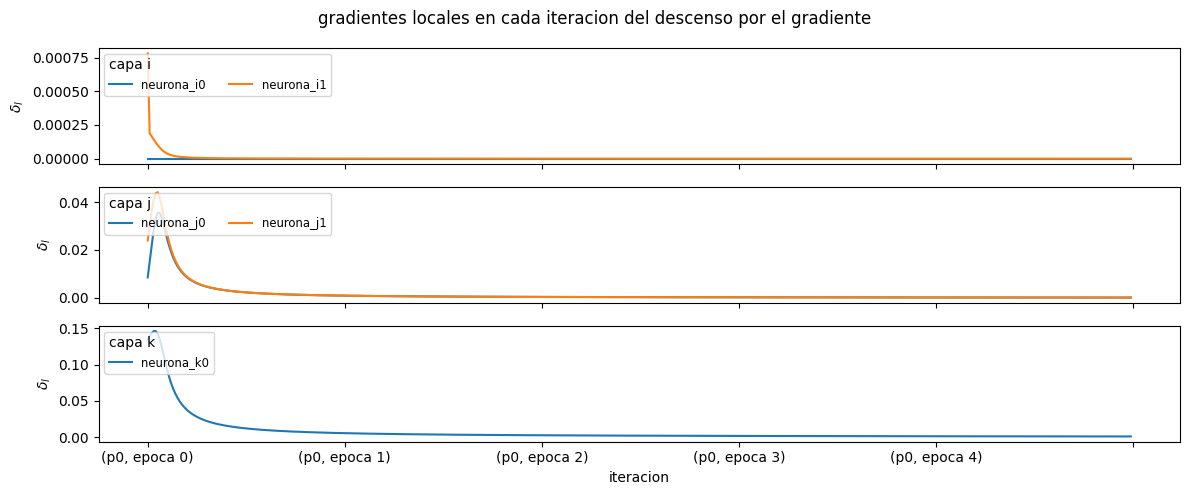

In [ ]:
# graficar los resultados
def grafica_individual (ax,df,ylabel,title):
  # graficar
  df.plot(ax=ax); ax.set_ylabel(ylabel); ax.set_xlabel("iteracion")
  # dar formato a las figuras
  lines, labels = [sum(x, []) for x in zip(*[ax.get_legend_handles_labels()])]
  ax.legend(lines, labels, loc='upper left', ncol=12, fontsize="small",title=title, alignment='left')

def graficas (w_local_grads,conf,capas_l,numero):
  # dar formato a la informacion guardada
  index=["(p%i, epoca %i)" %(i%len(X), int(i/len(X))) for i in range(len(w_local_grads))]
  name_neuronas=["neurona_%s%i" %(capa, neuronas) for capa in capas_l for neuronas in range(conf[capa])]
  df_local_grads=pd.DataFrame(np.array(w_local_grads),columns=name_neuronas,index=index).astype(float)

  fig, ax = plt.subplots(len(conf),1,figsize=(12,5),sharex=True)
  i=0; df=df_local_grads
  for capa_n, capa in enumerate(conf):
    l_capa=conf[capa]
    grafica_individual(ax[capa_n],df[df.columns[i:i+l_capa]],"$\\delta_l$","capa %s"%capa)
    fig.suptitle("gradientes locales en cada iteracion del descenso por el gradiente")
    i+=l_capa
  fig.tight_layout(); plt.savefig('gradientes_anasofiagutierrez_%i.png'%numero)

# descenso por el gradiente
def dJ_dw_func(phi,v,w,init_local_grad,x,dict_vals):
  # phi' evaluado en los campos de la capa
  dy_dv=Matrix(w.shape[0],1, lambda i,j: diff(phi,"v").subs({"v":v[i].evalf(subs=dict_vals)}))
  # terminar de calcular el gradiente local
  local_grad=init_local_grad.multiply_elementwise(dy_dv)
  # calcular el gradiente
  dJ_dw=local_grad*x.evalf(subs=dict_vals).T
  # iniciar el calculo del gradiente local para la capa siguiente
  next_local_grad=w.T*local_grad
  return dJ_dw, local_grad, next_local_grad.evalf(subs=dict_vals)

def update_w_grad(phi,v,w,Y_prev,init_local_grad,w_vals,dict_vals,eta):
  dJ_dw, local_grad, next_init_local_grad=dJ_dw_func(phi,v,w,init_local_grad,Y_prev,dict_vals)
  w_grads=dJ_dw; w_vals+=eta*w_grads
  return w_vals, w_grads, local_grad, next_init_local_grad

from tqdm import tqdm
# modelo MLP
# Planteamiento forward
n=X.shape[1]; mx=Matrix(symarray('X', n)) # input
mi=2; phi_i=phi_2; li, wi, vi=build_layer(mx,mi,phi_i,"i")
mj=2; phi_j=phi_2; lj, wj, vj=build_layer(li,mj,phi_j,"j")
mk=Y_d.shape[1]; phi_k=phi_3; lk, wk, vk=build_layer(lj,mk,phi_k,"k")
model, w_vars= lk, list(wi)+list(wj)+list(wk) # output

# w inicial aleatoria
np.random.seed(15)
wi_vals,wj_vals,wk_vals=[Matrix(np.random.rand(w.shape[0],w.shape[1])) for w in [wi,wj,wk]]
dict_vals=dict(set(zip(wi,wi_vals))|set(zip(wj,wj_vals))|set(zip(wk,wk_vals)))

# calcular gradientes para el punto p y, en cada capa, actualizar w de manera secuencial
epocas=5; eta=1
w_vals=[list(wi_vals)+list(wj_vals)+list(wk_vals)]; w_local_grads=[]; w_grads=[]
for iteracion in tqdm(range(len(X)*epocas)):
  p=iteracion%len(X)
  dict_vals.update(dict(set(zip(mx,X[p]))))
  #wk
  de_dy=-1*(Y_d[p].reshape((-1,1))-model.evalf(subs=dict_vals))
  wk_vals,wk_grads,wk_local_grads,init_local_grad_j=update_w_grad(phi_k,vk,wk,lj,de_dy,wk_vals,dict_vals,eta)
  dict_vals.update(dict(zip(wk,wk_vals)))
  #wj
  wj_vals,wj_grads,wj_local_grads,init_local_grad_i=update_w_grad(phi_j,vj,wj,li,init_local_grad_j,wj_vals,dict_vals,eta)
  dict_vals.update(dict(zip(wj,wj_vals)))
  #wi
  wi_vals,wi_grads,wi_local_grads, init_local_grad_0 = update_w_grad(phi_i,vi,wi,Matrix(X[p]),init_local_grad_i,wi_vals,dict_vals,eta)
  dict_vals.update(dict(zip(wi,wi_vals)))
  # guardar las funciones
  w_vals.append(list(wi_vals)+list(wj_vals)+list(wk_vals))
  w_grads.append(list(wi_grads)+list(wj_grads)+list(wk_grads))
  w_local_grads.append(list(wi_local_grads)+list(wj_local_grads)+list(wk_local_grads))

graficas(w_local_grads,{'i':mi,'j':mj,'k':mk},['i','j','k'],1)

# planteamiento matricial: resolver de manera secuencial con todos los patrones disponibles

In [ ]:
# requerimientos
import numpy as np
from sympy import *
import pandas as pd
import matplotlib.pyplot as plt
import sys

class MLP:
  __slots__ = ["wx","y","conf"]
  def __init__(self,layers_setup,X):
    self.wx=Matrix(symarray('X', X.shape[1]))
    self.y=None
    # configuration dictionary
    self.conf={}
    self.build_model(layers_setup) # informacion de capa capa
    self.rnd_w_vals() # inicializar valores w aleatorios

  def rnd_w_vals(self):
    for layer in self.conf:
      self.conf[layer].update({"W_vals":Matrix(np.random.rand(self.conf[layer]['W'].shape[0],self.conf[layer]['W'].shape[1]))})

  def build_model(self,layers_setup):
    last_layer=-1
    for layer,(neuronas,phi) in enumerate(layers_setup):
      entrada= self.conf[last_layer]['Y'] if last_layer!=-1 else self.wx
      self.conf[layer]=dict(zip([sys.intern('Y'),sys.intern('W'),sys.intern('V')],self.build_layer(entrada,neuronas,phi,layer)))
      self.conf[layer].update({'X':entrada,'Phi':phi})
      last_layer=layer
    self.y=self.conf[last_layer]['Y']

  def build_layer(self,x,m,phi,label):
    n=int(x.shape[0]) # entradas a cada perceptron
    W=Matrix(symarray('W'+str(label), (m, n))) # variables w para la capa
    V=W*x # campo local inducido en cada perceptron
    # funcion de activacion evaluada en el campo de los m perceptrones
    Y=Matrix(m,1, lambda i,j: phi.subs({"v":V[i,j]}))
    return Y, W, V

# descenso por el gradiente
def dJ_dw_func(phi,v,w,init_local_grad,x,dict_vals):
  # phi' evaluado en los campos de la capa
  dy_dv=Matrix(w.shape[0],1, lambda i,j: diff(phi,"v").subs({"v":v[i].xreplace(dict_vals)}))
  # terminar de calcular el gradiente local: init_local_grad*dy_dv
  local_grad=init_local_grad.multiply_elementwise(dy_dv)
  # calcular el gradiente
  dJ_dw=local_grad*x.xreplace(dict_vals).T
  # iniciar el calculo del gradiente local para la capa siguiente
  next_local_grad=w.T*local_grad
  return dJ_dw, local_grad, next_local_grad.xreplace(dict_vals)

def grad_descent(X,Y_d,model,epocas=1,eta=1,tol=10**-2):
  # configuracion
  conf_dict=model.conf; model_Y=model.y; model_X=model.wx

  # valores w para evaluar en los gradientes y en el calculo del error
  dict_vals={}
  for layer in conf_dict: dict_vals.update(dict(zip(conf_dict[layer]["W"],conf_dict[layer]["W_vals"])))

  # orden para backpropagation
  layers_labels=sorted(conf_dict.keys(),reverse=True)

  # almacenar informacion de cada iteracion
  local_grads={layer:[] for layer in layers_labels}; avrg_error=[]

  pbar = tqdm(total=len(X)*epocas*len(layers_labels)) # create progress bar

  iteracion=0; eval_grad_dead=len(X)-1; grad_dead_at=None
  while iteracion < len(X)*epocas:
    p=iteracion%len(X); iteracion+=1
    # evaluar en X[p]
    dict_vals.update(dict(zip(model.wx,X[p])))
    # error desde la evaluacion forward
    e=Y_d[p].reshape((-1,1))-model_Y.xreplace(dict_vals)
    # guardar energia del error
    avrg_error.append((e.T*e)[0]/2)

    init_local_grad=-1*e
    for layer in layers_labels:
      # abrir informacion de la capa layer
      conf=conf_dict[layer]
      # calcular gradiente
      dJ_dw,local_grad,init_local_grad=dJ_dw_func(conf['Phi'],conf['V'],conf['W'],init_local_grad,conf['X'],dict_vals)
      # actualizar pesos W
      new_w_vals=conf['W_vals']+eta*dJ_dw
      # guardar pesos W actualizados de la capa
      conf_dict[layer].update({'W_vals':new_w_vals})
      # actualizar pesos actuales W en el dict de evaluacion, solo de la capa layer
      dict_vals.update(dict(zip(conf["W"],new_w_vals)))
      # guardar gradientes locales
      local_grads[layer].append(list(local_grad))
      pbar.update(1) # update progress bar

    # guardar en que iteracion muere el gradiente
    if grad_dead_at is None and iteracion>10 and all([(np.mean(local_grads[layer][-10:],axis=0)<tol).all() for layer in range(len([0,1,2]))]):
      print("gradients died first at iteration %i"%iteracion)
      grad_dead_at=iteracion
    # detenerse solo despues de la primera epoca is
    if iteracion>=eval_grad_dead and grad_dead_at:
      break

  for x in list(model_X): dict_vals.pop(x) # solo devolver los pesos W actuales (sin ultimo punto p)
  return local_grads, avrg_error, dict_vals, conf_dict, grad_dead_at

def guardar_informacion(model_label,avrg_error,local_grads,dfs,start,X_test,Y_d_test,dict_vals,grad_dead_at):
  energia_error,error,deltas,avrg_delta=dfs
  # guardar informacion
  end=time.time()
  # energia error
  df_error=pd.DataFrame(avrg_error,columns=pd.MultiIndex.from_tuples([('error',)+model_label]),dtype=float)
  energia_error=pd.concat([energia_error,df_error], axis=1); energia_error.to_csv("energia_errores.csv")

  # error en entrenamiento
  error.loc[model_label,'train $\\varepsilon_{avg}$']=df_error.mean().values[0]

  # error en test
  Y_x=model.y.xreplace(dict_vals)
  Y_pred=[list(Y_x.xreplace(dict(zip(model.wx,xp))))for xp in X_test]
  error.loc[model_label,'test $\\varepsilon_{avg}$']=np.mean([sum(e**2)/2 for e in (Y_d_test-Y_pred)])
  error.loc[model_label,'time [s]']=end-start

  # local gradients
  cols_label=lambda layer, neurons: pd.MultiIndex.from_tuples([("$\\delta_%s$"%layer,)+model_label+('neuron %i'%i,) for i in neurons])
  info_delta=lambda grad_info,layer: pd.DataFrame(grad_info,dtype=float,columns=cols_label(layer,range(len(grad_info[0]))))
  df_local_grads=pd.concat([info_delta(local_grads[layer],layer) for layer in pd.DataFrame(local_grads)],axis=1)
  deltas=pd.concat([deltas,df_local_grads], axis=1); deltas.to_csv("deltas.csv")

  # mean local gradients
  df_mean=df_local_grads.groupby(level=[0,1,2,3],axis=1).mean()
  avrg_delta=pd.concat([avrg_delta,df_mean], axis=1); avrg_delta.to_csv("avrg_deltas.csv")

  # estabilizacion
  df_stable_mean=df_local_grads.iloc[grad_dead_at:].groupby(level=[0],axis=1).mean()
  error.loc[model_label,df_stable_mean.columns]=df_stable_mean.mean(axis=0)[df_stable_mean.columns]
  error.to_csv("errores_train_test.csv")
  return energia_error, error, deltas, avrg_delta

def graficar_df(df,layout,y_label,x_label,title,rot=0,figsize=(7,4)):
  dim_names=set(df.columns.get_level_values(0))
  fig_x,fig_y= (1,len(dim_names)) if layout=="h" else (len(dim_names),1)
  fig, ax = plt.subplots(fig_x,fig_y,figsize=figsize,sharex=True,squeeze=False)
  for i, (dimension, df_) in enumerate(df.groupby(level=0,axis=1)):
    ix,iy= (0,i) if layout=="h" else (i,0)
    labels=df_[dimension].columns.tolist()
    df_.plot(ax=ax[ix,iy],style=["-"]*(len(labels)-1)+['--'],rot=rot,legend=False)
    ax[ix,iy].set_ylabel(y_label(i))
    ax[ix,iy].set_xlabel(x_label)
  fig.suptitle(title,y=1)
  fig.legend(labels,bbox_to_anchor=[0.5, 0.97],loc='upper center',ncol=12,fontsize="small",alignment='left')
  fig.tight_layout()

In [ ]:
from tqdm.notebook import tqdm

In [ ]:
# cargar archivo
File_data = np.loadtxt("final.txt", dtype=float, delimiter=',')
File_data = File_data/np.max(File_data,axis=0) # normalizar a [0,1]

# muestrear
n_data=len(File_data)
ix=np.random.choice(n_data, n_data, replace=False)
n_train=int(n_data*0.6); n_test=int(n_data*0.2); n_val=int(n_data*0.2)

data_train=File_data[ix[:n_train]]; data_train_sorted=File_data[np.sort(ix[:n_train])]
data_test=File_data[np.sort(ix[n_train:n_train+n_test])]
data_val=File_data[np.sort(ix[-n_val:])]

X = data_train[:,[0,1]]; Y_d = data_train[:,[2]]
X_sorted = data_train_sorted[:,[0,1]]; Y_d_sorted = data_train_sorted[:,[2]]
X_test=data_test[:,[0,1]]; Y_d_test = data_test[:,[2]]
X_val=data_val[:,[0,1]]; Y_d_val = data_val[:,[2]]

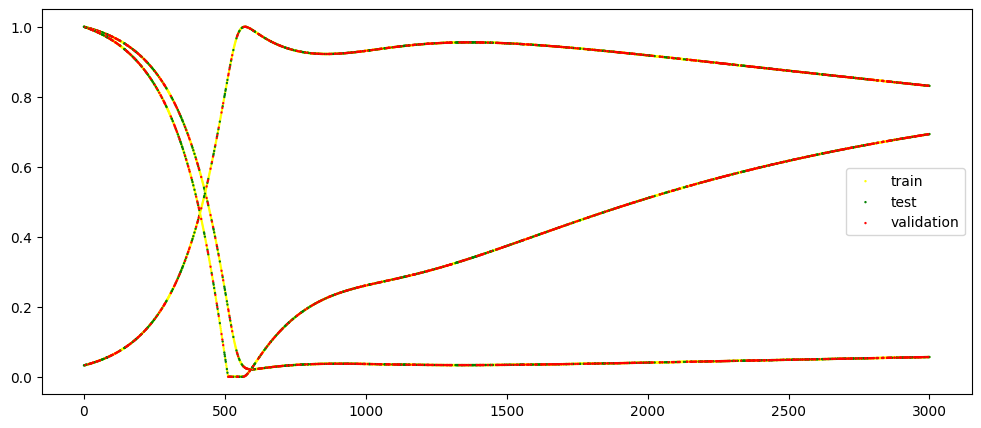

In [ ]:
fig=plt.figure(figsize=(12,5))
for xi in [0,1,2]:
  plt.scatter(np.sort(ix[:n_train]),data_train_sorted[:,[xi]],marker='.',s=2,c=['yellow']*n_train)
  plt.scatter(np.sort(ix[n_train:n_train+n_test]),data_test[:,[xi]],marker='.',s=2,c=['green']*n_test)
  plt.scatter(np.sort(ix[-n_val:]),data_val[:,[xi]],marker='.',s=2,c=['red']*n_val)

plt.legend(['train','test','validation'])

In [ ]:
X

array([[0.03401158, 0.95295626],
       [0.03014234, 0.94663624],
       [0.04314874, 0.90399737],
       ...,
       [0.03717736, 0.92234057],
       [0.03387658, 0.95105568],
       [0.039304  , 0.92496055]])

In [ ]:
import time
# inicializar df para guardar resultados
model_label_info=['layers', 'neurons', 'eta']
error=pd.DataFrame(columns=model_label_info+['%s $\\varepsilon_{avg}$'%s for s in ['train','test']]).set_index(model_label_info)
energia_error=pd.DataFrame(); avrg_delta=pd.DataFrame(); deltas=pd.DataFrame()
w_vals=pd.DataFrame(columns=model_label_info).set_index(model_label_info)

In [ ]:
# construir modelo
## funciones de activacion
a=1; b=0; v = symbols("v")
phi_1=a*v+b # lineal
phi_2=(exp(v)-exp(-v))/(exp(v)+exp(-v)) # tanh
phi_3=1/(1+exp(-v)) # sigmoid

## parametros
epocas=2; tol=0 # 10**-2
for L in [1,2,3]:
  for eta in [0.9,0.5,0.2]:
    print(L,' layers, ',eta,' eta')
    for mj in [1,2,3,5]:
      start=time.time()
      model=MLP([(X.shape[1],phi_2)]+[(mj,phi_3)]*L+[(Y_d.shape[1],phi_3)],X)
      # descenso por el gradiente
      local_grads,avrg_error,dict_vals,conf_dict,grad_dead_at=grad_descent(X,Y_d,model,epocas=epocas,eta=eta,tol=tol)
      model_label=('L=%i'%L, '$l_i$=%i'%mj,'$eta=%.2f$'%eta)
      w_vals.loc[model_label,dict_vals.keys()]=dict_vals
      energia_error,error,deltas,avrg_delta=guardar_informacion(model_label,
                                                                avrg_error,local_grads,
                                                                [energia_error,error,deltas,avrg_delta],
                                                                start,X_test,Y_d_test,dict_vals,grad_dead_at)
      break
    break
  break

1  layers,  0.9  eta


  0%|          | 0/10800 [00:00<?, ?it/s]

gradients died first at iteration 11


analizar informacion

In [ ]:
error.sort_index()

,,,train $\varepsilon_{avg}$,test $\varepsilon_{avg}$,time [s],$\delta_0$,$\delta_1$,$\delta_2$
layers,neurons,eta,,,,,,
L=1,$l_i$=1,$eta=0.90$,0.157865,0.154940004139646,49.977272,0.000716,0.001296,0.004531


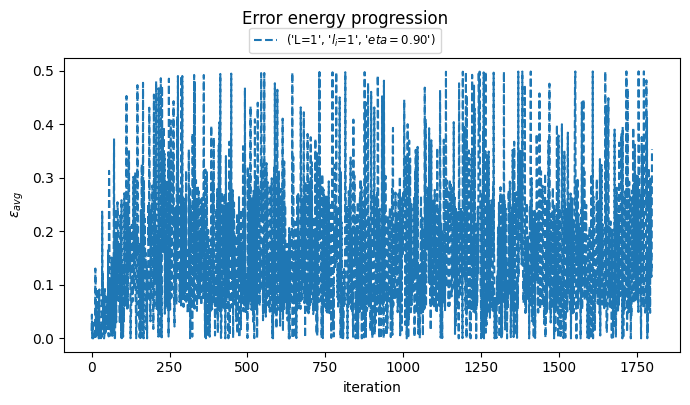

In [ ]:
#.xs(("L=2",'$eta=0.9$'),level=[1,3],axis=1)
graficar_df(energia_error,'v',lambda i: "$\\varepsilon_{avg}$","iteration","Error energy progression",rot=0)

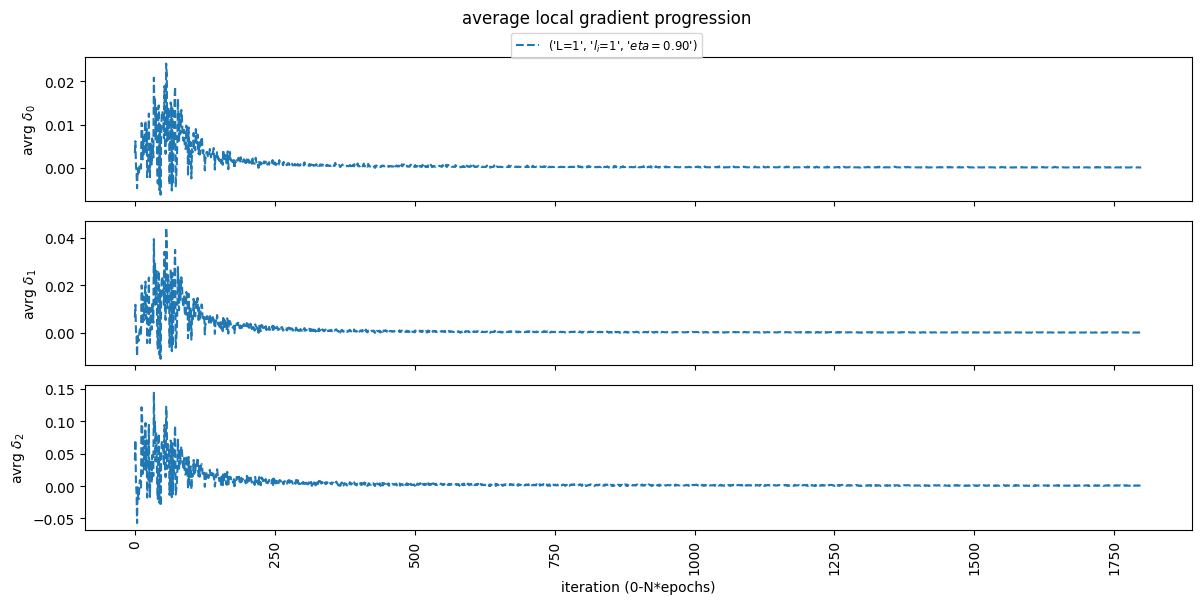

In [ ]:
#.xs(("L=3",'$eta=0.2$'),level=[1,3],axis=1)
graficar_df(avrg_delta,'v',lambda i: "avrg $\\delta_%s$"%i,'iteration (0-N*epochs)',"average local gradient progression",
            rot=90,figsize=(12,6))

In [ ]:
# error.drop("$eta=0.0$",level=2,axis=0)
w_vals.sort_index()

,,,W0_0_0,W0_0_1,W0_1_0,W0_1_1,W1_0_0,W1_0_1,W2_0_0
layers,neurons,eta,,,,,,,
L=1,$l_i$=1,$eta=0.90$,0.990815493954700,1.60948417454577,0.243195047494030,1.34020310468881,2.35203322289608,1.82378995484451,6.87469337899601


  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

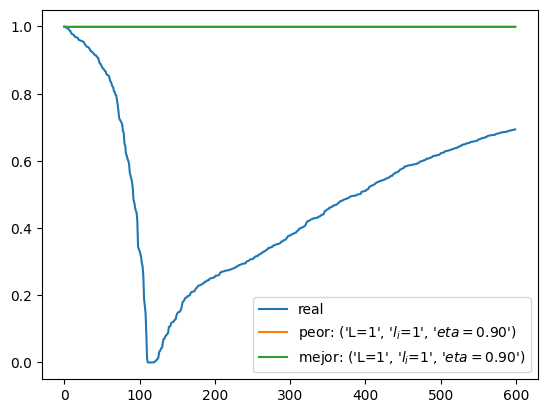

In [ ]:
plt.plot(Y_d_test)
graficar=['peor','mejor']
names=[error[error.iloc[:,1]==error.iloc[:,1].max()].index[0],
      error[error.iloc[:,1]==error.iloc[:,1].min()].index[0]]
#.drop("$eta=0.0$",level=2,axis=0)

for i, model_name in enumerate(names):
  # para recuperar mejor, peor y avrg modelos y pesos
  dict_vals_aux=w_vals.loc[model_name].to_dict()
  L=int(model_name[0].split("=")[1]); mj=int(model_name[1].split("=")[1])
  model=MLP([(X.shape[1],phi_2)]+[(mj,phi_2)]*L+[(Y_d.shape[1],phi_3)],X)
  Y_x=model.y.xreplace(dict_vals_aux); wx=model.wx
  # graficar salida sobre datos test
  names[i]= "%s: %s"%(graficar[i],names[i])
  Y_pred=[list(Y_x.xreplace(dict(zip(wx,xp)))) for xp in tqdm(X_test)]
  plt.plot(Y_pred)
plt.legend(['real']+names)

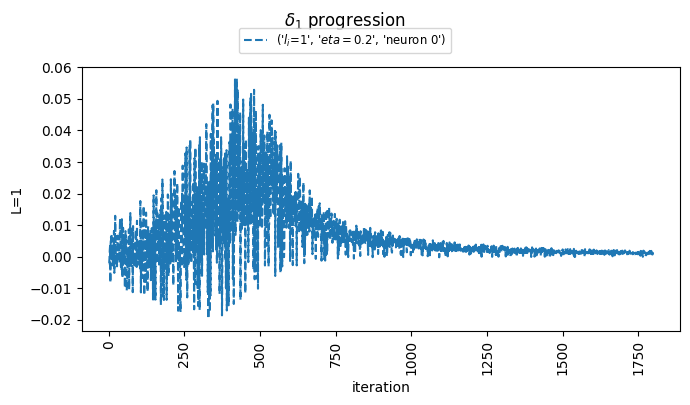

In [ ]:
delta_label="$\delta_1$"
graficar_df(deltas[delta_label],'h',lambda i: list(deltas[delta_label].columns.levels[0])[i],'iteration',delta_label+" progression",rot=90)

# additional code

In [ ]:
# Modelo general - salida deseada
M1 = lambda X: np.array([[all(xi)*1]*2 for xi in X]) #and
M2 = lambda X: np.array([[any(xi)*1] for xi in X]) #or
M3 = lambda X: np.array([[(any(xi) and not all(xi))*1] for xi in X]) #xor

# Solucionar el problema de aprendizaje
X=np.array([(0,0),(0,1),(1,0),(1,1)]) # 1. Entradas: x puntos en el espacio R^n
Y_d=M1(X)
Y_d=Y_d/np.max(Y_d, axis=0) # normalizar
Y_d

# datos andres
File_data = pd.read_excel("data.xlsx", dtype=float)
X = File_data[['AT','V',	'AP',	'RH']].to_numpy()[:100]
Y_d=File_data[['EP']].to_numpy()[:100]
X_test=File_data[['AT','V',	'AP',	'RH']].to_numpy()[100:200]
Y_d_test = File_data[['EP']].to_numpy()[100:200]

ValueError: ignored

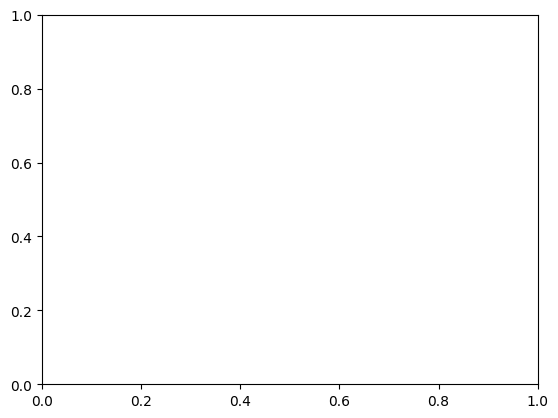

In [ ]:
dim_names=["output %i"%i for i in range(len(Y_d[0]))]
df_p = pd.concat([pd.DataFrame(x, columns=['real','predicted'],index=dim_names,dtype=float).T for x in [zip(*point) for point in zip(Y_d,Y_pred)]],
                axis=0,keys=range(len(X))).unstack()

ep=df_p.groupby(level=0,axis=1).apply(lambda x: (x[(x.name,'real')]-x[(x.name,'predicted')])**2/2).sum(axis=1)
ep.mean()

df_p

In [ ]:
graficar_df(df_p,'v',lambda i: "$Y_%i$"%i,"input p","MLP Output values")

In [ ]:
def graficar_localgrads(local_grads,n_puntos,eta,n_xticks):
  fig, ax = plt.subplots(len(local_grads),1,figsize=(12,7),sharex=True)
  index=["(p%i, epoch %i)" %(i%len(X), int(i/len(X))+1) for i in range(n_puntos)]
  for layer in local_grads:
    neuron_label=["neuron_%i"%i for i in range(len(local_grads[layer][0]))]
    ax[layer].plot(index,local_grads[layer],
                   label=neuron_label if len(neuron_label)!=1 else neuron_label[0])
    ax[layer].plot(index,np.mean(local_grads[layer],axis=1),
                   label="average $\\delta_%s$"%layer,linestyle='--')
    # dar formato
    ax[layer].set_ylabel("$\\delta_%s$"%layer);
    ax[layer].legend(loc='upper right',ncol=12,fontsize="small",alignment='left')
  ax[layer].set_xlabel("iteration")
  ax[layer].set_xticks(ax[layer].get_xticks()[::int(len(index)/n_xticks)],
                       index[::int(len(index)/n_xticks)],rotation=90,
                       fontsize='small')
  fig.suptitle("Local gradient progression with $\eta$=%.2f"%eta)
  plt.tight_layout(); plt.savefig('gradientes_anasofiagutierrez.png')

def graficar_salidas(X,Y_d,Y):
  dim_names=["output %i"%i for i in range(len(Y_d[0]))]
  df = pd.concat([pd.DataFrame(x, columns=['real','prediction'],index=dim_names,dtype=float).T for x in [zip(*point) for point in zip(Y_d,Y)]],
                axis=0,keys=range(len(X))).unstack()
  fig, ax = plt.subplots(1,len(dim_names),figsize=(7,4),sharex=True,squeeze=False)
  for i, (dimension, df_) in enumerate(df.groupby(level=0,axis=1)):
    df_.plot(ax=ax[0,i],legend=False)
    ax[0,i].set_ylabel("$Y_%i$"%i)
    ax[0,i].set_xlabel("input p")
  fig.legend(labels=['real','predicted'],loc='upper left',ncol=12,fontsize="small")
  fig.suptitle("MLP Output values")
  fig.tight_layout();  fig.savefig('salida_anasofiagutierrez.png')
  return df

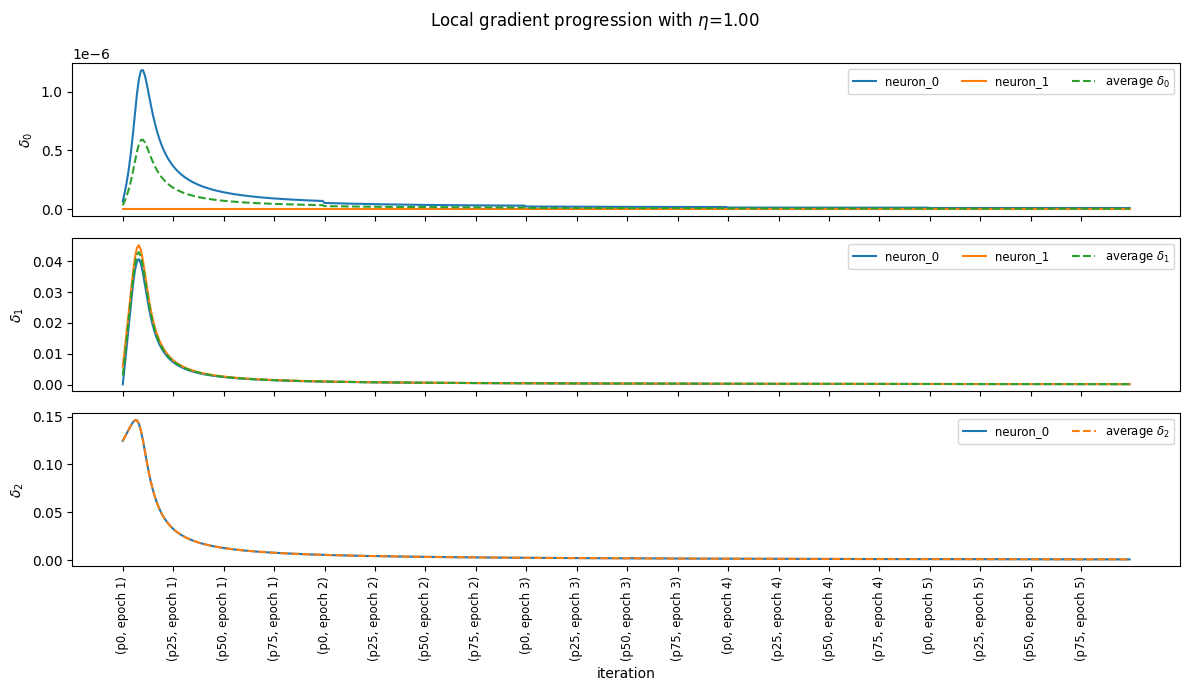

In [ ]:
graficar_localgrads(local_grads,len(local_grads[0]),eta,n_xticks=20)

array([<Axes: >], dtype=object)

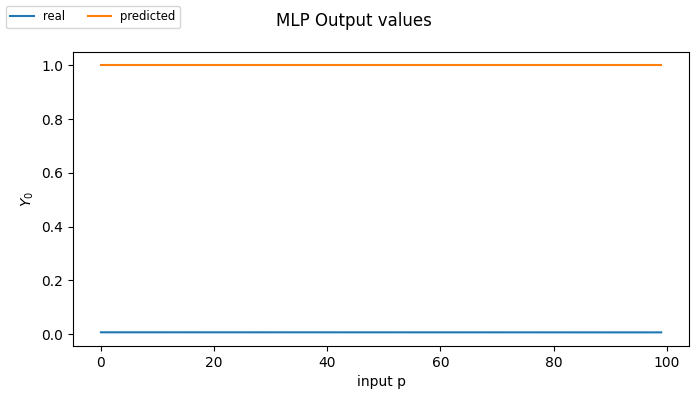

In [ ]:
df_outputs=graficar_salidas(X,Y_d,Y_pred)